In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import Callback

Preprocessing and Augmentation of Dataset

In [3]:
base_dir = r"C:\Dataset\Data"
output_dir = r"C:\Dataset\AugTensorData"

os.makedirs(output_dir, exist_ok=True)

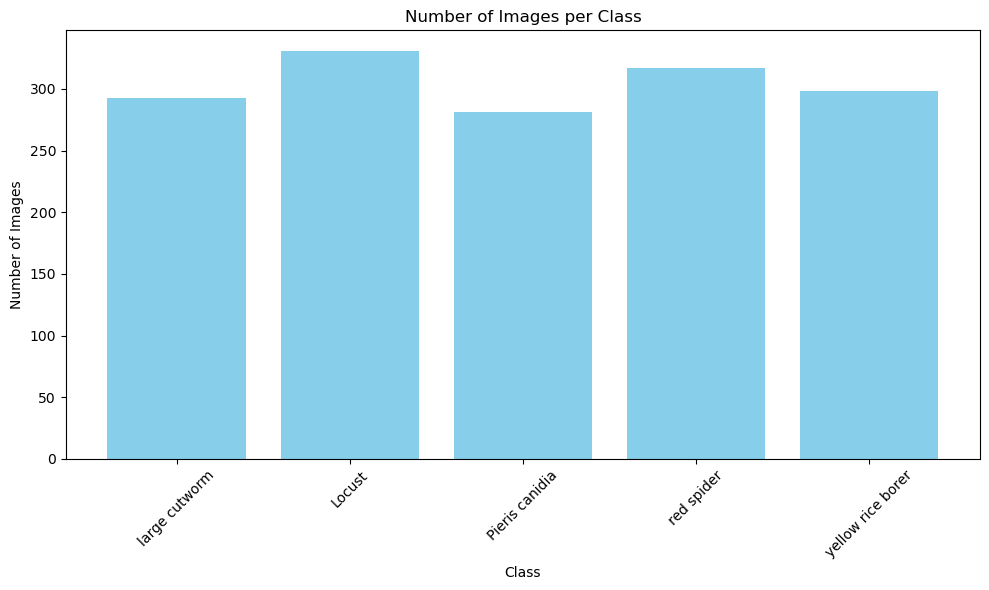

Class 'large cutworm': 293 images
Class 'Locust': 331 images
Class 'Pieris canidia': 281 images
Class 'red spider': 317 images
Class 'yellow rice borer': 298 images


In [4]:
def count_images_in_classes(base_dir):
    class_counts = {}
    
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = image_count
    
    return class_counts

def display_class_counts(class_counts):
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    for class_name, count in class_counts.items():
        print(f"Class '{class_name}': {count} images")

class_counts = count_images_in_classes(base_dir)
display_class_counts(class_counts)

In [ ]:
def apply_augmentations(img):
    augmentations = []
    
    def add_augmentation(image, title):
        augmentations.append((image, title))

    rotation_angle = random.choice(range(-40, -19)) if random.choice([True, False]) else random.choice(range(20, 41))
    rotated_image = img.rotate(rotation_angle)
    add_augmentation(rotated_image, f"Rotation {rotation_angle}°")
    
    if random.choice([True, False]):
        add_augmentation(img.transpose(Image.FLIP_LEFT_RIGHT), "Horizontal Flip")
    else:
        add_augmentation(img.transpose(Image.FLIP_TOP_BOTTOM), "Vertical Flip")

    zoom_factor = random.uniform(1.2, 1.8) 
    img_width, img_height = img.size
    zoomed_width = int(img.width / zoom_factor)
    zoomed_height = int(img.height / zoom_factor)
    left = (img.width - zoomed_width) // 2
    top = (img.height - zoomed_height) // 2
    right = (img.width + zoomed_width) // 2
    bottom = (img.height + zoomed_height) // 2
    zoomed = img.crop((left, top, right, bottom)).resize((img.width, img.height))
    add_augmentation(zoomed, f"Zoom In {zoom_factor:.2f}")

    brightness_factor = random.uniform(0.5, 0.6)
    add_augmentation(ImageEnhance.Brightness(img).enhance(brightness_factor),
                     f"Brightness {brightness_factor:.2f}")

    saturation_factor = random.uniform(2.5, 3.5)  
    saturated_image = ImageEnhance.Color(img).enhance(saturation_factor)
    add_augmentation(saturated_image, f"Saturation {saturation_factor:.2f}")

    def adjust_hue(image, hue_factor):
        img_hsv = image.convert("HSV")
        h, s, v = img_hsv.split()
        h = h.point(lambda p: (p + hue_factor) % 256)
        img_hue_adjusted = Image.merge("HSV", (h, s, v)).convert("RGB")
        return img_hue_adjusted
    hue_factor = random.randint(-30, -20) 
    hue_adjusted_image = adjust_hue(img, hue_factor)
    add_augmentation(hue_adjusted_image, f"Hue Adjustment {hue_factor}")

    def add_gaussian_noise(image):
        img_array = np.array(image)
        noise = np.random.normal(4, 8, img_array.shape).astype(np.uint8)
        noisy_image = Image.fromarray(np.clip(img_array + noise, 0, 255).astype(np.uint8))
        return noisy_image
    noisy_img = add_gaussian_noise(img)
    add_augmentation(noisy_img, "Gaussian Noise")

    blur_radius = random.uniform(0.8, 1.2) 
    blurred_image = img.filter(ImageFilter.GaussianBlur(blur_radius))
    add_augmentation(blurred_image, f"Blur Radius {blur_radius:.2f}")

    return augmentations

In [6]:
def convert_to_tensor(image):
    img_array = img_to_array(image) / 255.0  # Normalize to [0, 1]
    return tf.convert_to_tensor(img_array)

In [7]:
def display_augmented_images(image_path, img_height, img_width):
    img = Image.open(image_path).resize((img_width, img_height))
    augmented_images = apply_augmentations(img)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    tensors = []
    
    for i, (aug_img, title) in enumerate(augmented_images):
        plt.subplot(3, 3, i + 2)
        plt.imshow(aug_img)
        plt.title(title)
        plt.axis('off')
        tensor = convert_to_tensor(aug_img)
        tensors.append(tensor)

    plt.tight_layout()
    plt.show()
    
    return tensors

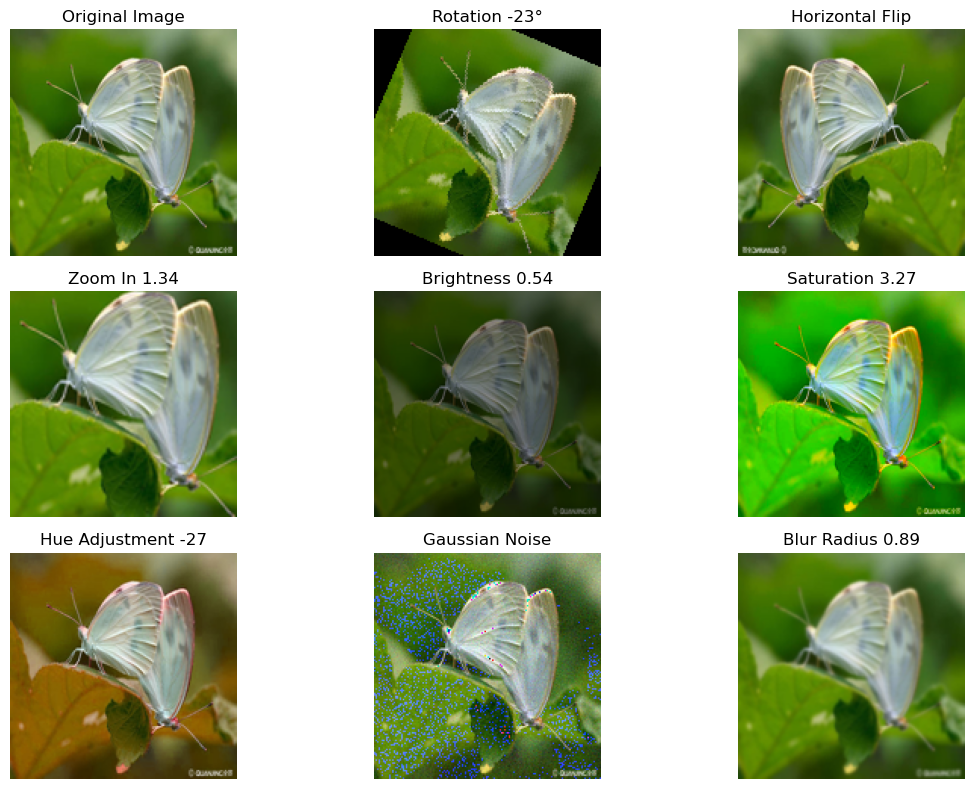

In [8]:
image_path = r"C:\Dataset\Data\Pieris canidia\40552.jpg"
img_height, img_width = 150, 150 
tensors = display_augmented_images(image_path, img_height, img_width)

In [ ]:
def convert_images_to_tensors(base_dir, output_dir, img_height, img_width):
    for label in os.listdir(base_dir):
        label_dir = os.path.join(base_dir, label)
        output_label_dir = os.path.join(output_dir, label)

        os.makedirs(output_label_dir, exist_ok=True)

        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = load_img(img_path, target_size=(img_height, img_width))
            
            augmentations = apply_augmentations(img)
            
            for i, (aug_img, title) in enumerate(augmentations):
                tensor_filename = f"{os.path.splitext(img_file)[0]}_{title.replace(' ', '_')}_{i}.npy"  
                img_array = img_to_array(aug_img) 
                img_array = img_array / 255.0 
                np.save(os.path.join(output_label_dir, tensor_filename), img_array) 

img_height, img_width = 150, 150

In [11]:
convert_images_to_tensors(base_dir, output_dir, img_height, img_width)

Training the data

In [2]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

In [4]:
img_height, img_width = 150, 150
batch_size = 32
num_classes = 5
epochs_per_run = 20 

In [5]:
output_dir = r"C:\Dataset\AugTensorData"

model_dir = 'model'
history_dir = 'history'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

X = []
y = []

for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        for file in os.listdir(label_dir):
            if file.endswith('.npy'):
                img_array = np.load(os.path.join(label_dir, file))
                X.append(img_array)
                y.append(label)

X = np.array(X)
y = np.array(y)

In [6]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

1. Resnet Model

In [47]:
def identity_block(x, filter):
    x_skip = x

    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [48]:
def convolutional_block(x, filter):
    x_skip = x
    
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2), kernel_regularizer=regularizers.l2(0.001))(x_skip)
    
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [49]:
def ResNet(shape, classes):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    block_layers = [2, 2, 2]
    filter_size = 64
    
    for i in range(3):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size *= 2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)

    x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.5)(x) 
    x = tf.keras.layers.Dense(classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)
    
    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet14")
    return model

In [ ]:
input_shape = (150, 150, 3) 
num_classes = 5  

ResNetmodel = ResNet(input_shape, num_classes)

ResNetmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [51]:
ResNetmodel.summary()

Model: "ResNet14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 156, 156, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 78, 78, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                           

In [52]:
resnet_history = ResNetmodel.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs_per_run,  
    batch_size=batch_size,)

Epoch 1/20
326/326 [==============================] - 219s 658ms/step - loss: 3.1609 - accuracy: 0.3578 - precision: 0.4750 - recall: 0.1092 - auc: 0.6855 - val_loss: 2.6401 - val_accuracy: 0.2821 - val_precision: 0.3779 - val_recall: 0.1259 - val_auc: 0.6319
Epoch 2/20
326/326 [==============================] - 217s 667ms/step - loss: 1.9276 - accuracy: 0.5191 - precision: 0.6677 - recall: 0.2972 - auc: 0.8264 - val_loss: 1.9403 - val_accuracy: 0.5347 - val_precision: 0.6437 - val_recall: 0.4230 - val_auc: 0.8017
Epoch 3/20
326/326 [==============================] - 213s 653ms/step - loss: 1.5015 - accuracy: 0.5955 - precision: 0.7238 - recall: 0.4256 - auc: 0.8708 - val_loss: 1.5858 - val_accuracy: 0.5344 - val_precision: 0.6001 - val_recall: 0.4499 - val_auc: 0.8381
Epoch 4/20
326/326 [==============================] - 176s 539ms/step - loss: 1.2674 - accuracy: 0.6458 - precision: 0.7527 - recall: 0.4987 - auc: 0.8946 - val_loss: 1.2557 - val_accuracy: 0.6299 - val_precision: 0.7227

In [ ]:
ResNetmodel.save(os.path.join(model_dir, 'ResNetmodel.h5'))
np.save(os.path.join(history_dir, 'train_history_ResNetmodel.npy'), resnet_history.history)

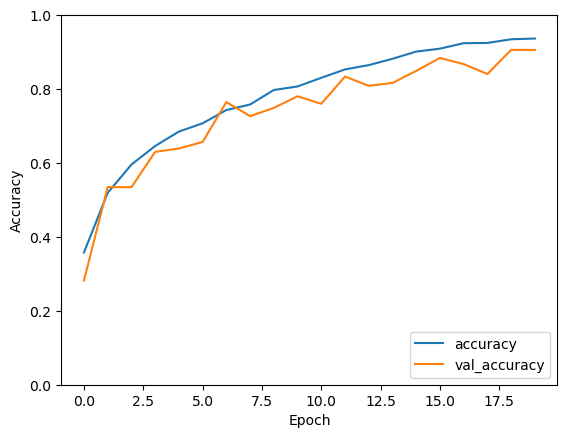

In [54]:
plt.plot(resnet_history.history['accuracy'], label='accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

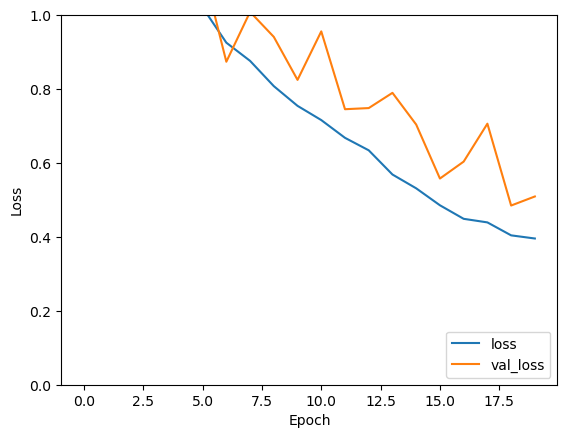

In [60]:
plt.plot(resnet_history.history['loss'], label='loss')
plt.plot(resnet_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Performance Metrics

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [57]:
y_pred = ResNetmodel.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1) 

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

82/82 [==============================] - 12s 146ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       504
           1       0.90      0.94      0.92       437
           2       0.93      0.88      0.90       665
           3       0.90      0.95      0.92       511
           4       0.91      0.88      0.90       488

    accuracy                           0.91      2605
   macro avg       0.90      0.91      0.91      2605
weighted avg       0.91      0.91      0.91      2605



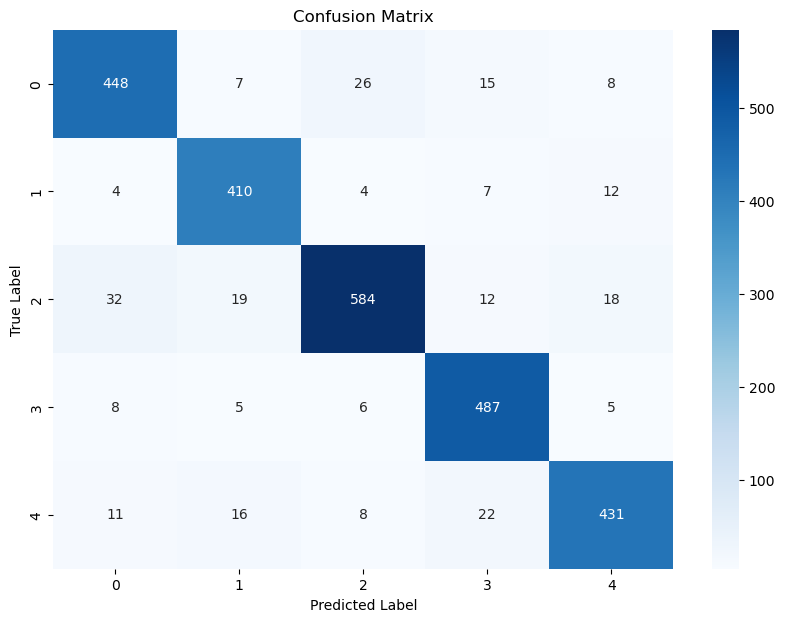

In [58]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

2. GoogleNet

In [7]:
def inception_module(x, filters):
    branch1x1 = tf.keras.layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch3x3 = tf.keras.layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = tf.keras.layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)

    branch5x5 = tf.keras.layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = tf.keras.layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch5x5)

    outputs = tf.keras.layers.concatenate([branch1x1, branch3x3, branch5x5], axis=-1)
    return outputs

In [8]:
def GoogleNet(shape, classes):
    x_input = tf.keras.layers.Input(shape)

    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(x_input)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = tf.keras.layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [64, 128, 128, 32, 32]) 
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [128, 192, 192, 64, 64])
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    

    x = tf.keras.layers.Dropout(0.5)(x) 
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

    x = tf.keras.layers.Dense(classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="GoogleNet")
    return model

In [9]:
input_shape = (150, 150, 3) 
num_classes = 5 

GoogleNetmodel = GoogleNet(input_shape, num_classes)
GoogleNetmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])


In [10]:
GoogleNetmodel.summary()

Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 38, 38, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 38, 38, 192)  110784      ['max_pooling2d[0][0]']  

In [48]:
googlenet_history = GoogleNetmodel.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs_per_run,  
    batch_size=batch_size,)

Epoch 1/20
326/326 [==============================] - 114s 341ms/step - loss: 1.5603 - accuracy: 0.3465 - precision: 0.5804 - recall: 0.0658 - auc: 0.6950 - val_loss: 1.3635 - val_accuracy: 0.4933 - val_precision: 0.8723 - val_recall: 0.0472 - val_auc: 0.7894
Epoch 2/20
326/326 [==============================] - 110s 337ms/step - loss: 1.1513 - accuracy: 0.5494 - precision: 0.6777 - recall: 0.3306 - auc: 0.8417 - val_loss: 1.0979 - val_accuracy: 0.6004 - val_precision: 0.7936 - val_recall: 0.3159 - val_auc: 0.8672
Epoch 3/20
326/326 [==============================] - 104s 319ms/step - loss: 0.9761 - accuracy: 0.6309 - precision: 0.7277 - recall: 0.4825 - auc: 0.8889 - val_loss: 0.9121 - val_accuracy: 0.6687 - val_precision: 0.8072 - val_recall: 0.4821 - val_auc: 0.9134
Epoch 4/20
326/326 [==============================] - 88s 270ms/step - loss: 0.8650 - accuracy: 0.6836 - precision: 0.7632 - recall: 0.5751 - auc: 0.9139 - val_loss: 0.8699 - val_accuracy: 0.6914 - val_precision: 0.8325 

In [49]:
GoogleNetmodel.save(os.path.join(model_dir, 'GoogleNetmodel.h5'))
np.save(os.path.join(history_dir, 'train_history_GoogleNetmodel.npy'), googlenet_history.history)

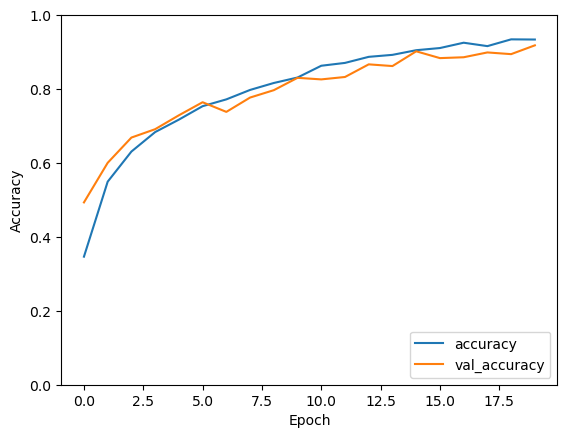

In [50]:
plt.plot(googlenet_history.history['accuracy'], label='accuracy')
plt.plot(googlenet_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

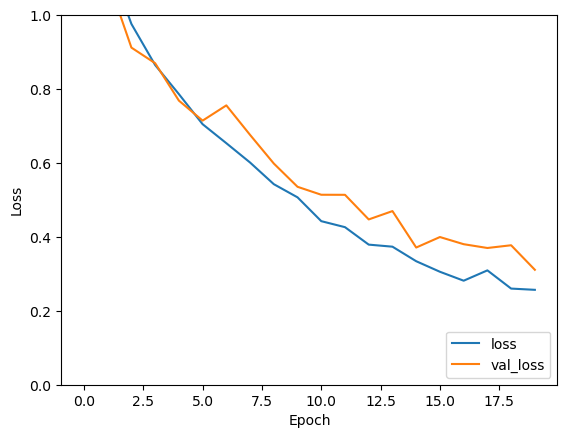

In [ ]:
plt.plot(googlenet_history.history['loss'], label='loss')
plt.plot(googlenet_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Performance Metrics

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [56]:
y_pred = GoogleNetmodel.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1) 

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

82/82 [==============================] - 7s 84ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       504
           1       0.96      0.93      0.95       437
           2       0.88      0.94      0.91       665
           3       0.95      0.93      0.94       511
           4       0.93      0.90      0.92       488

    accuracy                           0.92      2605
   macro avg       0.92      0.92      0.92      2605
weighted avg       0.92      0.92      0.92      2605



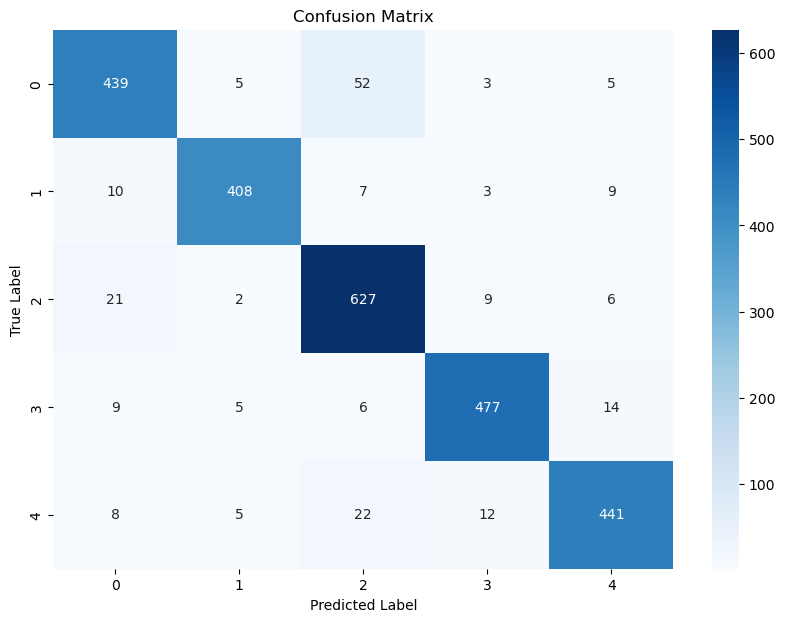

In [57]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

3. Custom Model

In [6]:
def inception_module(x, filters):
    branch1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch3x3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = layers.Conv2D(filters[2], (1, 3), padding='same', activation='relu')(branch3x3)
    branch3x3 = layers.Conv2D(filters[2], (3, 1), padding='same', activation='relu')(branch3x3)

    branch5x5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = layers.Conv2D(filters[4], (3, 3), padding='same', activation='relu')(branch5x5)
    branch5x5 = layers.Conv2D(filters[4], (1, 3), padding='same', activation='relu')(branch5x5)
    branch5x5 = layers.Conv2D(filters[4], (3, 1), padding='same', activation='relu')(branch5x5)
    
    branch_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)  
    branch_pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    outputs = layers.concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return outputs

In [ ]:
def transformer_block(x, num_heads, key_dim):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn = layers.Dense(2048, activation='relu')(x)
    ffn = layers.Dense(x.shape[-1])(ffn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)

    return x

In [7]:
def residual_block(x, filters):
    shortcut = x
    
    x = layers.Conv2D(filters, (1, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, (3, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
    
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    
    return x


In [ ]:
def CustomModel(shape, classes):
    x_input = layers.Input(shape)

    x = layers.Conv2D(64, (1, 3), strides=2, padding='same', activation='relu')(x_input)
    x = layers.Conv2D(64, (3, 1), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = layers.Conv2D(128, (1, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 1), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [64, 128, 128, 32, 32, 32])
    x = layers.Dropout(0.25)(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [128, 192, 192, 64, 64, 64]) 
    x = layers.Dropout(0.25)(x)

    x = residual_block(x, 192)

    x_shape = tf.keras.backend.int_shape(x) 
    x = layers.Reshape((x_shape[1] * x_shape[2], x_shape[3]))(x)  
    x = transformer_block(x, num_heads=8, key_dim=64)
    x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x) 

    x = layers.AveragePooling2D((5, 5))(x) 
    x = layers.Flatten()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

    x = layers.Dense(classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="CustomModel")
    return model


In [ ]:
import tensorflow.keras.backend as K

def confident_categorical_loss(alpha=0.1):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        ce_loss = -K.sum(y_true * K.log(y_pred), axis=-1)
        confidence_penalty = alpha * K.sum(K.abs(y_pred - 0.5), axis=-1)
        
        return ce_loss + confidence_penalty
    
    return loss

In [26]:
input_shape = (150, 150, 3) 
num_classes = 5 

Custommodel = CustomModel(input_shape, num_classes)

Custommodel.compile(optimizer='adam', loss=confident_categorical_loss(alpha=0.1), metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [16]:
Custommodel.summary()

Model: "CustomModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_52 (Conv2D)             (None, 75, 75, 64)   640         ['input_3[0][0]']                
                                                                                                  
 conv2d_53 (Conv2D)             (None, 38, 38, 64)   12352       ['conv2d_52[0][0]']              
                                                                                                  
 max_pooling2d_11 (MaxPooling2D  (None, 19, 19, 64)  0           ['conv2d_53[0][0]']    

In [19]:
print(X_train.shape)  
print(X_val.shape)   

(10419, 150, 150, 3)
(2605, 150, 150, 3)


In [149]:
history = Custommodel.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs_per_run,  
    batch_size=batch_size,
)

Epoch 1/20
326/326 [==============================] - 89s 264ms/step - loss: 1.4855 - accuracy: 0.3305 - precision: 0.5053 - recall: 0.0275 - auc: 0.6749 - val_loss: 1.3244 - val_accuracy: 0.4683 - val_precision: 0.6033 - val_recall: 0.1401 - val_auc: 0.7743
Epoch 2/20
326/326 [==============================] - 63s 191ms/step - loss: 1.2619 - accuracy: 0.4647 - precision: 0.6300 - recall: 0.1881 - auc: 0.7912 - val_loss: 1.1156 - val_accuracy: 0.5274 - val_precision: 0.7530 - val_recall: 0.2845 - val_auc: 0.8424
Epoch 3/20
326/326 [==============================] - 66s 203ms/step - loss: 0.9939 - accuracy: 0.5986 - precision: 0.7073 - recall: 0.4149 - auc: 0.8753 - val_loss: 0.9201 - val_accuracy: 0.6361 - val_precision: 0.7567 - val_recall: 0.4979 - val_auc: 0.8943
Epoch 4/20
326/326 [==============================] - 71s 219ms/step - loss: 0.8469 - accuracy: 0.6707 - precision: 0.7579 - recall: 0.5472 - auc: 0.9101 - val_loss: 0.7737 - val_accuracy: 0.7132 - val_precision: 0.8351 - v

In [156]:
Custommodel.save(os.path.join(model_dir, 'Custommodel.h5'))
np.save(os.path.join(history_dir, 'train_history_Custommodel.npy'), history.history)

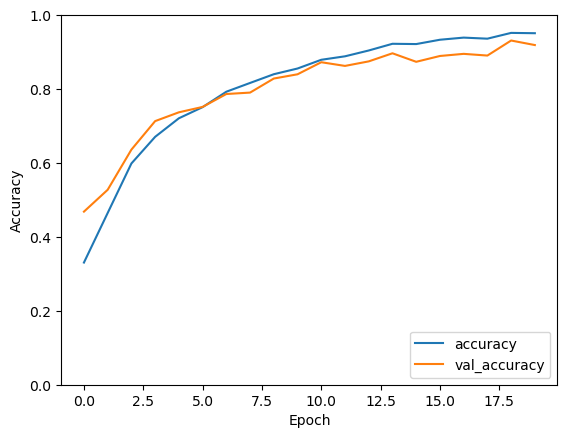

In [157]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

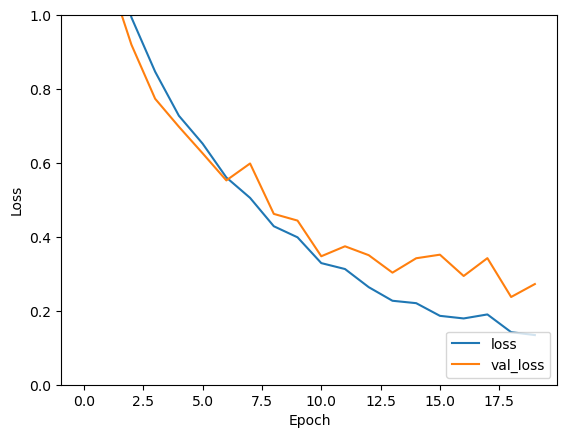

In [158]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Performance Metrics

In [159]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [160]:
y_pred = Custommodel.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_val, axis=1)  

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

82/82 [==============================] - 2s 26ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       504
           1       0.93      0.97      0.95       437
           2       0.94      0.87      0.90       665
           3       0.95      0.93      0.94       511
           4       0.90      0.94      0.92       488

    accuracy                           0.92      2605
   macro avg       0.92      0.92      0.92      2605
weighted avg       0.92      0.92      0.92      2605



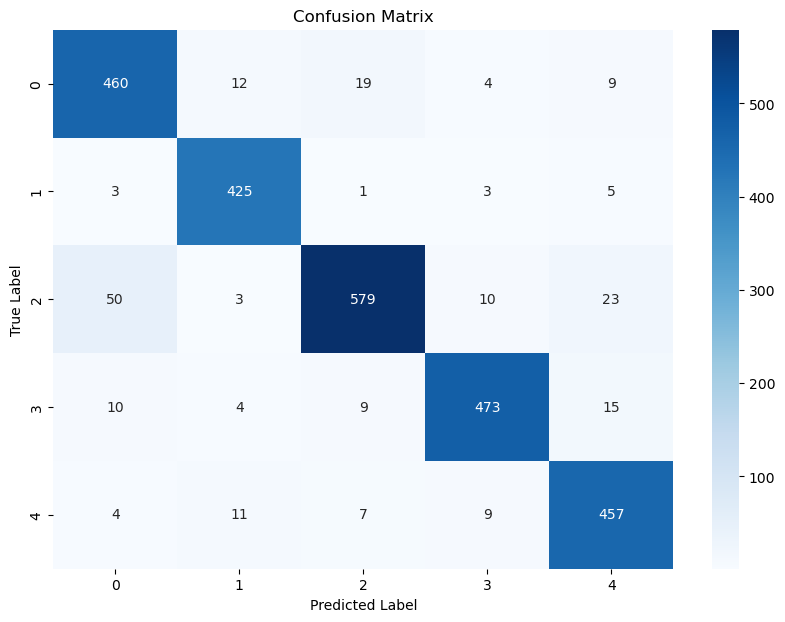

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()